In [1]:
import pickle
import pandas as pd
import numpy as np


from matplotlib import pyplot as plt



import os

import netCDF4
from netCDF4 import Dataset

from match2hydrolakes import match2hydrolakes, get_hylak_info

from importlib import reload
import kpmb_weather
reload(kpmb_weather)
from kpmb_weather import find_stations, download_weather_data, get_id

import datetime
from kpmb_lib import is_leap_year


from IPython.display import clear_output

volume = 'Data'
volume = 'My Passport for Mac'

suffix =''
suffix = '_v10b'
suffix = '_v11'
#suffix = '_v11b'

OUTPUT_DIR = f'/Volumes/{volume}/WeatherData/NOAA/'
CSV_DIR = OUTPUT_DIR+'csv/'

ISIMIP_DIR  = f'/Volumes/{volume}/ISIMIP/isimip3b/input/'
ISIMIP_DIR2 = f'/Volumes/{volume}/ISIMIP/'

CLIMATENA_DIR = '/Users/blagrave/Desktop/Folder to share/'


Code to build weather time series (historical NOAA or ISIMIP models)

In [2]:
X = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon_limited_seasonal_8params{suffix}_input.csv')
X.columns

Index(['Lake_area', 'Depth_avg', 'Elevation', 'TMINMAX_lagSON',
       'TMINMAX_lagJJA', 'TMINMAX_DJF'],
      dtype='object')

In [109]:
def get_jd(dataset, index=False):
    times = dataset.variables['time'][:]
    jd = netCDF4.num2date(times, dataset.variables['time'].units)
    if index:
        jd = pd.DatetimeIndex(jd)
    return jd

def coords_to_grid(coords):
    """
    Convert coords (lat,lon) to grid cell index
    Set to solve problem of 180 rows, 360 columns
       for ISIMIP data at 0.5 degree resolution
    """
    
    lat,lon = zip(*coords)
    lat = np.array(lat)
    lon = np.array(lon)
    # coordinate of first row and first column
    lat0 = 89.75
    lon0 = -179.75
    cellsize = 0.5 # degrees/cell
    
    # lat (degrees) -> cell units (cell#)
    #                             cellsize (degrees/cell)
    
    # 180 by 360 cells
    # y is between 0 and 179
    # x is between 0 and 359
    
    # convert to grid cell index
    y = np.round((lat0-lat)/cellsize).astype(int)
    x = np.round((lon-lon0)/cellsize).astype(int)
    # print((lat0-lat)/cellsize,y)
    # print((lon-lon0)/cellsize,x)
    return y,x

def get_isimip_filename(year, model='ipsl-cm6a-lr', ssp='ssp585'):
    #isimip_dir  = '/Volumes/Data/ISIMIP/input/'
    firstdate = np.max([((year-1) // 10 )*10 + 1, 2015])
    seconddate = ((year-1) // 10 +1)*10
    #if ((seconddate == 2100) | (seconddate == 2300)) & (((rcp=='rcp26') & (model in ['HadGEM2-ES','IPSL-CM5A-LR','MIROC5'])) |
    #                           ((rcp=='rcp85') & (model in ['IPSL-CM5A-LR']))
    #                          ):
    #    if seconddate == 2300:
    #        seconddate = 2299
    #elif (seconddate == 2100):
    #    seconddate = 2099
    #firstdate = f"{firstdate}0101"
    #seconddate = f"{seconddate}1231"
    filename = ISIMIP_DIR + f'{model}_r1i1p1f1_w5e5_{ssp}_tasAdjust_landonly2b_daily_{firstdate}_{seconddate}.nc'
    #filename = isimip_dir + f'tas_day_{model}_{rcp}_r1i1p1_EWEMBI_landonly_{firstdate}-{seconddate}.nc'
    return filename

def build_isimip_weather_series_rcp(lat,lon, start_date, end_date, verbose=True, model='GFDL-ESM2M', rcp='rcp26'):

    varia = 'tasAdjust'
    
    year = pd.to_datetime(start_date).year
    
    if year < 2006:
        print(f'NO DATA in {year}: ISIMIP data begins in 2006-2007 winter season.')
    
    dfresult = pd.DataFrame(index=pd.date_range(start_date,end_date))
    
    filename = get_isimip_filename(year, model=model, rcp=rcp)
    try:
        dataset = Dataset(filename)
    except:
        print(f'Can not find {filename}')
        dfresult[varia] = np.nan
        return dfresult.reset_index().rename({'index':'DATE',varia:'Tavg'},axis=1)
    
        
    ts = get_jd(dataset)
    ind = (ts >= pd.to_datetime(start_date)) & (ts <= pd.to_datetime(end_date))
    #lakes = [(89.025,63.2), (89.23,63.1), (88.77,62.1), ()]
    #y,x = [(0,165),(0,165), (3,164)]           
    y,x = coords_to_grid([(lat,lon)])
    
    # convert from Kelvin to Celsius
    tmp = dataset[varia][ind,y[0],x[0]].data - 273.15
    
    dfresult.loc[:dfresult.index[len(tmp)-1],varia] = tmp
    
    # if in a decadal year, need to read in next file too and append files
    if year % 10 == 0:
        filename = get_isimip_filename(year+1, model=model, rcp=rcp)
        dataset = Dataset(filename)
        
        ts = get_jd(dataset)
        ind = (ts >= pd.to_datetime(start_date)) & (ts <= pd.to_datetime(end_date))

        y,x = coords_to_grid([(lat,lon)])
        ind2 = dfresult[varia].isnull()
        dfresult.loc[ind2,varia] = dataset[varia][ind,y[0],x[0]].data - 273.15
    
    return dfresult.reset_index().rename({'index':'DATE',varia:'Tavg'},axis=1)


def build_isimip_weather_series(lat,lon, start_date, end_date, verbose=True, model='ipsl-cm6a-lr', historic=False,ssp='ssp585'):
    
    varia = 'tasAdjust'
    
    year = pd.to_datetime(start_date).year
    
    if historic:
    #    hist = 'hist'
        ssp = 'historical'
    #else:
    #    hist = ''
    if (year < 2015) & (not historic):
        print(f'NO DATA in {year}: ISIMIP data begins in 2015-2016 winter season.')
    
    start_date_dt = pd.to_datetime(f"{start_date} 00:00")
    end_date_dt= pd.to_datetime(f"{end_date} 23:59")
    
    try:
        dfmatch = pd.read_csv(f'/Volumes/{volume}/ISIMIP/isimip3b/input/match_index_v2.csv')
        filename = f"/Volumes/{volume}/ISIMIP/isimip3b/input/{model}_{ssp}_lakesonly.csv"
        dfresult = pd.read_csv(filename,index_col=0)
        dfresult.index = pd.to_datetime(dfresult.index)
        # convert to Celsius from Kelvin
        dfresult = dfresult - 273.15
        # and select row based on lat,lon
        ind = (np.abs(dfmatch.lat - lat) <0.005) & (np.abs(dfmatch.lon -lon) <0.005)
        
        #match_index = dfmatch.loc[ind,'match_index'].drop_duplicates().astype(str)[0]
        match_index = dfmatch.loc[ind,'match_index'].drop_duplicates().astype(str).values[0]

        ind = (dfresult.index>=start_date_dt) & (dfresult.index<=end_date_dt)

        dfresult = dfresult.loc[ind,match_index].to_frame().rename({match_index:varia},axis=1)

        #display(dfresult)

        return dfresult.reset_index().rename({'index':'DATE',varia:'Tavg'},axis=1)
    except:
        print('Reading from non-"lakesonly" file.')
        pass
    
    dfresult = pd.DataFrame(index=pd.date_range(start_date,end_date))
    
    filename = get_isimip_filename(year, model=model, ssp=ssp)
    try:
        dataset = Dataset(filename)
    except:
        print(f'Can not find {filename}')
        dfresult[varia] = np.nan
        return dfresult.reset_index().rename({'index':'DATE',varia:'Tavg'},axis=1)
    
    
    ts = get_jd(dataset)
    
    ind = (ts >= start_date_dt) & (ts <= end_date_dt)
    
    y,x = coords_to_grid([(lat,lon)])
    
    # convert from Kelvin to Celsius
    tmp = dataset[varia][ind,y[0],x[0]].data - 273.15
    
    dfresult.loc[:dfresult.index[len(tmp)-1],varia] = tmp
    
    # if in a decadal year, need to read in next file too and append files
    if year % 10 == 0:
        filename = get_isimip_filename(year+1, model=model, ssp=ssp)
        dataset = Dataset(filename)
        
        ts = get_jd(dataset)
        ind = (ts >= start_date_dt) & (ts <= end_date_dt)
        y,x = coords_to_grid([(lat,lon)])
        # convert from Kelvin to Celsius
        tmp =  dataset[varia][ind,y[0],x[0]].data - 273.15
        
        ind2 = dfresult[varia].isnull()
        dfresult.loc[ind2,varia] = tmp
    
    return dfresult.reset_index().rename({'index':'DATE',varia:'Tavg'},axis=1)

def build_weather_series(lat,lon, elevation, start_date, end_date, historic=True,  verbose=True,
                         DIR=f'/Volumes/{volume}/WeatherData/NOAA/csv/',
                        model='ipsl-cm6a-lr', ssp='ssp585', d_elev=100):
    if historic:
        dfresult = build_noaa_weather_series(lat, lon, elevation, start_date, end_date, DIR=DIR, verbose=verbose,d_elev=d_elev)
        dfresult['Tavg'] = (dfresult.TMIN+dfresult.TMAX)/2.
    
        ind = dfresult.TMIN.isnull() | dfresult.TMAX.isnull() | (dfresult.TMAX < dfresult.TMIN)| (dfresult.TOBS> dfresult.TMAX)

        dfresult.loc[ind,'Tavg'] = np.nan

    else:
        dfresult = build_isimip_weather_series(lat,lon, start_date, end_date, verbose=verbose,model=model, ssp=ssp)
        #display(dfresult)
    dfresult = dfresult.Tavg.to_frame().T
        
    return dfresult
        
def build_noaa_weather_series(lat,lon, elevation, start_date, end_date,verbose=True,
                              DIR=f'/Volumes/{volume}/WeatherData/NOAA/csv/', d_elev=100):
    

    delta_elev_ft = d_elev*3.28084 #  metres converted to feet
    elev_ft = elevation * 3.28084
    
    # DIR is directory where weather station data gets saved
    _ = download_weather_data(lat,lon,dfstations, dist=50, start_date=start_date,
                         end_date=end_date, download_all=True, verbose=verbose)
    
    # dfstations_temp is subset of dfstations that have some air temperature data (TMIN, TMAX, TAVG)
    
    stations,_,distances = find_stations(lat, lon, dfstations_temp,
                          dist=50, verbose=verbose,elev=elev_ft, d_elev=delta_elev_ft,
                          start_date=start_date, end_date=end_date)
    
    other_stations = get_id(lat, lon, dfstations_temp, elev=elev_ft, d_elev=delta_elev_ft, dist=50, getid='GHCND_ID')
    
    df_lakecode = pd.DataFrame(index=pd.date_range(start_date, end_date))
    
    # cycles from most to least coverage
    for key,value in stations.items():
        #d1min = min(d1).strftime('%Y-%m-%d')
        #d1max = max(d1).strftime('%Y-%m-%d')
        ghcnd_id = dfstations_temp[dfstations_temp.NCDCSTN_ID==key].GHCND_ID.dropna().unique()
        #ghcnd_id should be length of 1 so loop may not be necessary
        for ghcnd in ghcnd_id:
            filename = f'{DIR}{ghcnd}.csv'
            try:
                dfoo = pd.read_csv(filename)
            except:
                print('file not found error.')
                continue
            dfoo = dfoo.set_index('DATE')
            dfoo.index = pd.to_datetime(dfoo.index)
            
            # check quality attributes and remove bad data
            for var in ['TMIN','TMAX','TAVG']:
                dfoo[var] = dfoo[var].astype(float)
                if f'{var}_ATTRIBUTES' in dfoo.columns:
                    ind_flag = ~dfoo[f'{var}_ATTRIBUTES'].astype(str).str.split(',').str[1].astype(str).str.strip().isin(['','nan'])
                    dfoo.loc[ind_flag,var] = np.nan
            
            dfoo['TMINMAX'] = (dfoo['TMIN'] + dfoo['TMAX'])/2.
            ind = dfoo.TMINMAX.isnull() & ~dfoo.TAVG.isnull()
            dfoo.loc[ind,'TMINMAX'] = dfoo.loc[ind,'TAVG'].copy()
            
            station = dfoo.STATION.drop_duplicates().tolist()[0]
            # fills in blanks with data from other stations
            
            if df_lakecode.shape[1]==0:
                df_lakecode = df_lakecode.merge(dfoo,left_index=True,right_index=True, how='left')
            
                df_lakecode['TMINMAX'] = (df_lakecode['TMIN']+ df_lakecode['TMAX'])/2.
                ind = df_lakecode.TMINMAX.isnull() & ~df_lakecode.TAVG.isnull()
                df_lakecode.loc[ind,'TMINMAX'] = df_lakecode.loc[ind,'TAVG'].copy()
            
            
            else:
                ind_rows = df_lakecode.TMINMAX.isnull() & ~dfoo.TMINMAX.isnull()
            
                df_lakecode.loc[ind_rows,:] = dfoo.loc[ind_rows,:].copy()
                
                #df_lakecode= df_lakecode.fillna(dfoo)
    # now fillna using other_stations
    for ghcnd in other_stations:
        filename = f'{DIR}{ghcnd}.csv'
        try:
            dfoo = pd.read_csv(filename)
        except:
            print('file not found error.')
            continue
        if len(dfoo)==0:
            continue
        
        dfoo = dfoo.set_index('DATE')
        dfoo.index = pd.to_datetime(dfoo.index)
        
        # check quality attributes and remove bad data
        for var in ['TMIN','TMAX','TAVG']:
            dfoo[var] = dfoo[var].astype(float)
            if f'{var}_ATTRIBUTES' in dfoo.columns:
                ind_flag = ~dfoo[f'{var}_ATTRIBUTES'].astype(str).str.split(',').str[1].astype(str).str.strip().isin(['','nan'])
                dfoo.loc[ind_flag,var] = np.nan

        dfoo['TMINMAX'] = (dfoo['TMIN'] + dfoo['TMAX'])/2.
        ind = dfoo.TMINMAX.isnull() & ~dfoo.TAVG.isnull()
        dfoo.loc[ind,'TMINMAX'] = dfoo.loc[ind,'TAVG'].copy()
        
        if df_lakecode.shape[1]==0:
            df_lakecode = df_lakecode.merge(dfoo,left_index=True,right_index=True, how='left')
            
            df_lakecode['TMINMAX'] = (df_lakecode['TMIN']+ df_lakecode['TMAX'])/2.
            ind = df_lakecode.TMINMAX.isnull() & ~df_lakecode.TAVG.isnull()
            df_lakecode.loc[ind,'TMINMAX'] = df_lakecode.loc[ind,'TAVG'].copy()
            
        else:
            #df_lakecode= df_lakecode.fillna(dfoo)
            # consistently fill in data only if TMINMAX is missing
            ind_rows = df_lakecode.TMINMAX.isnull() & ~dfoo.TMINMAX.isnull()
            
            df_lakecode.loc[ind_rows,:] = dfoo.loc[ind_rows,:].copy()
            
    #df_lakecode['lakecode']= row.name
    #df_lakecode['lake'] = row.lake

    df_lakecode = df_lakecode.reset_index().rename({'index':'DATE'},axis=1)
    
    return df_lakecode


X = pd.read_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff_limited_seasonal_6params{suffix}_input.csv')


maxSON, maxDJF, maxMAM, maxJJA = X['TMINMAX_lagSON'].max(), X['TMINMAX_DJF'].max(), X['TMINMAX_MAM'].max(), X['TMINMAX_lagJJA'].max()
minSON, minDJF, minMAM, minJJA = X['TMINMAX_lagSON'].min(), X['TMINMAX_DJF'].min(), X['TMINMAX_MAM'].min(), X['TMINMAX_lagJJA'].min()



def predict_phenology(lat, lon, year, rf_model='seasonal', verbose = True, depth_avg = None, 
                      historic = True, model = 'ipsl-cm6a-lr',ssp='ssp585', extrapolation = False,
                      lake_area = None, shore_dev = None, slope_100 = None, elevation=None,
                     climateNA = False):
    
    if rf_model=='daily':
        with open('/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon.pickle', 'rb') as f:
            rf_iceon = pickle.load(f)
        with open('/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff.pickle', 'rb') as f:
            rf_iceoff = pickle.load(f)
    else:
        with open(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon_limited_seasonal_8params{suffix}.pickle', 'rb') as f:
            rf_iceon = pickle.load(f)
        with open(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff_limited_seasonal_6params{suffix}.pickle', 'rb') as f:
            rf_iceoff = pickle.load(f)
    
    if isinstance(year, list):
        maxyear = np.max(year)
    else:
        maxyear = year
    if (datetime.datetime(maxyear+1, 6,1) > datetime.datetime.now()) & historic:
        print('There is no historic record for this year. Try running predict_phenology with argument [historic=False].')
        return np.nan, np.nan
        
    latlon = f'{lat:+07.3f}{lon:+08.3f}'
    
    if (depth_avg is None) | (lake_area is None) | (shore_dev is None) | (slope_100 is None) | (elevation is None):
        hylak_dist, hylak_id = match2hydrolakes(lat, lon)
        if np.isnan(hylak_dist):
            print('No HydroLAKES match at this coordinate. You need to supply depth_avg, lake_area, shore_len.')
            #print(f'\tClosest HydroLAKES lake {hylak_id} is {hylak_dist:.1f} km away.')
            return np.nan, np.nan
        lakechar = get_hylak_info(hylak_id)
    else:
        lakechar = dict(Depth_avg=depth_avg, Lake_area=lake_area, Shore_dev=shore_dev, Slope_100=slope_100, Elevation=elevation)
    
    elevation = lakechar['Elevation']
    
    # earliest and latest day of year used in model prediction
    if rf_model == 'daily':
        earliest, latest = -100, 145
    else: # 1 June, May 31
        earliest = -213
        if is_leap_year(maxyear+1):
            latest = 152
        else:
            latest = 151
    
    if isinstance(year, list):
        start_date = (pd.to_datetime(f'31 December {np.min(year)}') + pd.to_timedelta(f'{earliest} days')).strftime('%d %B, %Y')
        end_date = (pd.to_datetime(f'31 December {np.max(year)}') + pd.to_timedelta(f'{latest} days')).strftime('%d %B, %Y')    
    else:
        start_date = (pd.to_datetime(f'31 December {year}') + pd.to_timedelta(f'{earliest} days')).strftime('%d %B, %Y')
        end_date = (pd.to_datetime(f'31 December {year}') + pd.to_timedelta(f'{latest} days')).strftime('%d %B, %Y')
    
    if verbose:
        print(f'Building weather time series for coordinate ({lat:.3f},{lon:.3f})')
        print(f'  {start_date} to {end_date}') 
    if not climateNA:
        tavg = build_weather_series(lat, lon, elevation, start_date, end_date, historic=historic, 
                                model=model, ssp=ssp, verbose=verbose)
    
        if verbose:
            print('\nMissing days in Tavg series:', tavg.isnull().sum(axis=1).values[0])

        if rf_model=='daily':
            tavg.columns = range(earliest,latest+1)
        else:
            # aggregate tavg
            tavg.columns = pd.date_range(start_date, end_date)
            tavg = tavg.T.resample('Q-FEB').mean().T
            if isinstance(year,list):
                tavg = tavg.stack().reset_index()
                tavg['year'] = tavg.level_1.apply(lambda x: x.year if x.month>7 else x.year-1)
                tavg['season'] = tavg.level_1.dt.month.replace({8:'TMINMAX_lagJJA',11:'TMINMAX_lagSON',2:'TMINMAX_DJF',5:'TMINMAX_MAM'})
                tavg = tavg.pivot_table(index='year',columns='season',values=0)[['TMINMAX_lagJJA','TMINMAX_lagSON','TMINMAX_DJF','TMINMAX_MAM']]
            #return tavg
            else:
                tavg.columns = ['TMINMAX_lagJJA','TMINMAX_lagSON','TMINMAX_DJF', 'TMINMAX_MAM']
                tavg.index = [latlon]
    else:
        # read in data from ClimateNA files (using model and ssp time series)
        # tavg from monthly to seasonal columns (Tave01, Tave02, etc.)
        tavg = pd.read_csv(CLIMATENA_DIR+f'US_icephenologymodels74lakes_{model.upper()}_{ssp}_2011-2100MP.csv')
        # modify this to find closest match
        ind = (tavg.Latitude == lat) & (tavg.Longitude == lon) & (tavg.Year.isin([year,year-1]))
        print('equal',ind.sum())
        ind = np.isclose(tavg.Latitude,lat) & np.isclose(tavg.Longitude,lon) & (tavg.Year.isin([year,year-1]))
        print('close',ind.sum())
        tavg = tavg.loc[ind,:]
        for mm in range(6,13):
            tavg[f'Tave_lag{mm:02d}'] = tavg[f'Tave{mm:02d}'].shift()
        #display(tavg[['Year','Latitude','Longitude','ID1','ID2']+[c for c in tavg.columns if ('Tave' in c)]])
        tavg = tavg.loc[tavg.Year==year,:]
        
        tavg['TMINMAX_lagJJA'] = (tavg[f'Tave_lag06'] + tavg[f'Tave_lag07'] + tavg[f'Tave_lag08'])/3.
        tavg['TMINMAX_lagSON'] = (tavg[f'Tave_lag09'] + tavg[f'Tave_lag10'] + tavg[f'Tave_lag11'])/3.
        tavg['TMINMAX_DJF'] = (tavg[f'Tave_lag12'] + tavg[f'Tave01'] + tavg[f'Tave02'])/3.
        tavg['TMINMAX_MAM'] = (tavg[f'Tave03'] + tavg[f'Tave04'] + tavg[f'Tave05'])/3.
        tavg = tavg[['TMINMAX_lagJJA','TMINMAX_lagSON','TMINMAX_DJF', 'TMINMAX_MAM']]
        tavg.index = [latlon]
        
    if verbose:
        display(tavg)
    
    if len(tavg.dropna(how='all',axis=0))==0:
        return np.nan, np.nan    

        
    #features = ['Shore_len', 'Depth_avg']
    features = ['Depth_avg', 'Lake_area']
    features_on = [i for i in rf_iceon.feature_names_in_ if i not in tavg.columns]
    features_off = [i for i in rf_iceoff.feature_names_in_ if i not in tavg.columns]
    
    iceon_multiple, iceoff_multiple = [],[]
    # run through all rows of tavg
    for i,row in tavg.iterrows():
        
        X = tavg.loc[[i],:].copy()
        X.index = [latlon]
        if rf_model == 'daily':
            X = X.fillna((X.shift(axis=1) + X.shift(-1,axis=1))/2.)
        # make sure all values are filled
            if X.isnull().any(axis=1).all():
                # find maximum number of consecutive NaN days
                ndays = X.T[X.index[0]].isnull().astype(int).groupby(X.T[X.index[0]].notnull().astype(int).cumsum()).sum().max()
                print(f'CAUTION: Temperatures are interpolated over {ndays} days.')
                print(f'Coordinates: {lat:+07.3f}, {lon:+08.3f}; Year: {year}')
                X = X.interpolate(axis=1)
    
        Xon = pd.concat([X,pd.DataFrame(lakechar,index=[latlon])[features_on]],ignore_index=False,axis=1)
        Xon.columns = Xon.columns.astype(str)
        Xon = Xon[rf_iceon.feature_names_in_]

        Xoff = pd.concat([X,pd.DataFrame(lakechar,index=[latlon])[features_off]],ignore_index=False,axis=1)
        Xoff.columns = Xoff.columns.astype(str)
        Xoff = Xoff[rf_iceoff.feature_names_in_]
    
    #if rf_model == 'daily':
    #    iceon = int(np.round(rf_iceon.predict(Xon)))
    #else:
    #    iceon = int(np.round(rf_iceon.predict(Xon.drop('TMINMAX_MAM',axis=1))))

        iceon = int(np.round(rf_iceon.predict(Xon)))

        iceoff = int(np.round(rf_iceoff.predict(Xoff)))
    
        if not extrapolation:
            if (tavg['TMINMAX_lagJJA'].between(minJJA, maxJJA).all() & 
                tavg['TMINMAX_lagSON'].between(minSON, maxSON).all() &
                tavg['TMINMAX_DJF'].between(minDJF, maxDJF).all() &
                tavg['TMINMAX_MAM'].between(minMAM, maxMAM).all()):
                iceoff = iceoff
            elif (tavg['TMINMAX_lagJJA'].between(minJJA, maxJJA).all() & 
                tavg['TMINMAX_lagSON'].between(minSON, maxSON).all() &
                tavg['TMINMAX_DJF'].between(minDJF, maxDJF).all()):
                iceon = iceon
                iceoff = np.nan
            else:
                iceon = np.nan
                iceoff = np.nan
        
        iceon_multiple.append(iceon)
        iceoff_multiple.append(iceoff)
    
    if isinstance(year,list):
        return iceon_multiple, iceoff_multiple
    else:
        return iceon_multiple[0], iceoff_multiple[0]



In [60]:
"""
ion,ioff =predict_phenology(lat,lon, list(np.arange(1960,2020)), historic=True, 
                                     rf_model='seasonal', 
                                     depth_avg=lakechar['Depth_avg'],
                                     lake_area=lakechar['Lake_area'],
                                     shore_dev=lakechar['Shore_dev'],
                                     elevation=lakechar['Elevation'],
                                     slope_100=lakechar['Slope_100'],
                                     #model=model, 
                                     #ssp = ssp, 
                                     verbose=True)
"""
pass

In [25]:
model = ['gfdl-esm4',#'ipsl-cm6a-lr',
         'mpi-esm1-2-hr','mri-esm2-0','ukesm1-0-ll']
lat,lon = 42.485,-85.332
for m in model:
    print(m)
    print(predict_phenology(lat,lon, 2080, historic=False, verbose=False,ssp='ssp126',
                            climateNA=True,model=m, rf_model='seasonal'))
    #print(predict_phenology(43.128,-89.42, 2023, historic=False, verbose=False,climateNA=False,model=m))

gfdl-esm4
(-22, 66)
mpi-esm1-2-hr
(-12, 59)
mri-esm2-0
(-13, 62)
ukesm1-0-ll
(nan, nan)


In [23]:
dfmatch[dfmatch.lakecode=='MICH06']

,lakecode,lake,start_date,end_date,lat,lon,Distance,Hylak_id,Match,Lake_name,...,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat,match_index
49,MICH06,fair,1955,2019,42.485,-85.332,0.0,1050788.0,True,NaN,...,3.0,4.2,0.045,981.2,278.0,2.21,5.2,-85.329766,42.49249,560


In [26]:


lat,lon = 43.128, -89.42
y,x = coords_to_grid([(lat,lon)])
year = 2050
model = 'gfdl-esm4'
rcp = 'ssp126'
filename = get_isimip_filename(year, model=model, ssp=rcp)
dataset = Dataset(filename)
print(y,x)
print(dataset['lon'][x].data, dataset['lat'][y].data)

[93] [181]
[-89.25] [43.25]


In [27]:
dataset['lon'][x].data, dataset['lat'][y].data

(array([-89.25]), array([43.25]))

In [38]:
lat,lon =np.nan,np.nan
model = ['gfdl-esm4','ipsl-cm6a-lr','mpi-esm1-2-hr','mri-esm2-0','ukesm1-0-ll']
model = 'gfdl-esm4'
model = 'ukesm1-0-ll'
ssp = 'ssp126'

for lc in ['DMR1','DMR2','JJM18']:
    lat,lon = df_uslakes[df_uslakes.lakecode==lc][['latitude','longitude']].values[0]
    print(lat,lon)

    elevation = 258
    verbose=True

    start_date = '1988-01-01'
    end_date = '2020-12-31'
    tavghist = build_weather_series(lat, lon, elevation, start_date, end_date, historic=True, 
                                    model=model, ssp=ssp, verbose=verbose)
    tavghist.columns = pd.date_range(start_date, end_date)
    tavghist = tavghist.T.resample('Q-FEB').mean()
    #tavghist.columns = ['TMINMAX_lagJJA','TMINMAX_lagSON','TMINMAX_DJF', 'TMINMAX_MAM']
    start_date = '2015-01-01'
    end_date = '2100-12-31'
    tavg = build_weather_series(lat, lon, elevation, start_date, end_date, historic=False, 
                                    model=model, ssp=ssp, verbose=verbose)
    tavg.columns = pd.date_range(start_date, end_date)
    tavg = tavg.T.resample('Q-FEB').mean()
    ax=tavghist.plot()
    tavg.plot(ax=ax)
    #tavg.columns = ['TMINMAX_lagJJA','TMINMAX_lagSON','TMINMAX_DJF', 'TMINMAX_MAM']

NameError: name 'df_uslakes' is not defined

Looking at range of temperatures.

In [16]:
with open(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon_limited_seasonal_8params{suffix}.pickle', 'rb') as f:
    rf_iceon = pickle.load(f)
with open(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff_limited_seasonal_6params{suffix}.pickle', 'rb') as f:
    rf_iceoff = pickle.load(f)

# Mendota (DMR1)
lat,lon = 43.128, -89.42

latlon = f'{lat:+07.3f}{lon:+08.3f}'

hylak_dist, hylak_id = match2hydrolakes(lat, lon)
if np.isnan(hylak_dist):
    print('No HydroLAKES match at this coordinate. You need to supply depth_avg, lake_area, shore_len.')
    #print(f'\tClosest HydroLAKES lake {hylak_id} is {hylak_dist:.1f} km away.')
lakechar = get_hylak_info(hylak_id)
elevation = lakechar['Elevation']

alliceon = []
df0 = pd.DataFrame()
for winter_T in np.linspace(-15,8,24):
    for fall_T in np.linspace(3,20,18):
        tavg = pd.DataFrame([20,fall_T,winter_T,10]).T
        tavg.columns = ['TMINMAX_lagJJA','TMINMAX_lagSON','TMINMAX_DJF', 'TMINMAX_MAM']
        tavg.index = [latlon]

        features = ['Depth_avg', 'Lake_area']
        features_on = [i for i in rf_iceon.feature_names_in_ if i not in tavg.columns]
        features_off = [i for i in rf_iceoff.feature_names_in_ if i not in tavg.columns]

        X = tavg.copy()
        Xon = pd.concat([X,pd.DataFrame(lakechar,index=[latlon])[features_on]],ignore_index=False,axis=1)
        Xon.columns = Xon.columns.astype(str)
        Xon = Xon[rf_iceon.feature_names_in_]

        Xoff = pd.concat([X,pd.DataFrame(lakechar,index=[latlon])[features_off]],ignore_index=False,axis=1)
        Xoff.columns = Xoff.columns.astype(str)
        Xoff = Xoff[rf_iceoff.feature_names_in_]
        iceon = int(np.round(rf_iceon.predict(Xon)))
        iceoff = int(np.round(rf_iceoff.predict(Xoff)))
        if (winter_T > maxDJF) | (fall_T > maxSON):
            iceon = -999
        df0 = df0.append(pd.DataFrame({'winter_T':[winter_T],'fall_T':[fall_T],'iceon':[iceon]},index=[0]),ignore_index=True)

for winter_T in np.linspace(-15,8,24):
    for spring_T in np.linspace(-1,16,18):
        tavg = pd.DataFrame([20,10,winter_T,spring_T]).T
        tavg.columns = ['TMINMAX_lagJJA','TMINMAX_lagSON','TMINMAX_DJF', 'TMINMAX_MAM']
        tavg.index = [latlon]

        features = ['Depth_avg', 'Lake_area']
        features_on = [i for i in rf_iceon.feature_names_in_ if i not in tavg.columns]
        features_off = [i for i in rf_iceoff.feature_names_in_ if i not in tavg.columns]

        X = tavg.copy()
        Xon = pd.concat([X,pd.DataFrame(lakechar,index=[latlon])[features_on]],ignore_index=False,axis=1)
        Xon.columns = Xon.columns.astype(str)
        Xon = Xon[rf_iceon.feature_names_in_]

        Xoff = pd.concat([X,pd.DataFrame(lakechar,index=[latlon])[features_off]],ignore_index=False,axis=1)
        Xoff.columns = Xoff.columns.astype(str)
        Xoff = Xoff[rf_iceoff.feature_names_in_]
        iceon = int(np.round(rf_iceon.predict(Xon)))
        iceoff = int(np.round(rf_iceoff.predict(Xoff)))
        if (winter_T > maxDJF) | (spring_T > maxMAM):
            iceoff = -999
        df0 = df0.append(pd.DataFrame({'winter_T':[winter_T],'spring_T':[spring_T],'iceoff':[iceoff]},index=[0]),ignore_index=True)

        
        

NameError: name 'dfstations' is not defined

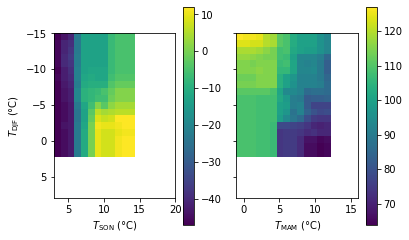

In [18]:
from matplotlib import pyplot as plt

fig,axes = plt.subplots(1,2, sharey = True)

ax1 = axes.flatten()[0]
ax2 = axes.flatten()[1]

ind = ~df0.iceon.isnull()
img1 = ax1.imshow(df0[ind].iceon.replace(-999,np.nan).values.reshape(24,18), extent=[df0[ind].fall_T.min(),df0[ind].fall_T.max(),
                                                    df0[ind].winter_T.max(),df0[ind].winter_T.min()])
fig.colorbar(img1,ax=ax1)
ax1.set_ylabel('$T_\mathrm{DJF}$ (\N{DEGREE SIGN}C)')
ax1.set_xlabel('$T_\mathrm{SON}$ (\N{DEGREE SIGN}C)')

ind = ~df0.iceoff.isnull()
img2 = ax2.imshow(df0[ind].iceoff.replace(-999,np.nan).values.reshape(24,18), extent=[df0[ind].spring_T.min(),df0[ind].spring_T.max(),
                                                    df0[ind].winter_T.max(),df0[ind].winter_T.min()])
fig.colorbar(img2,ax=ax2)
#ax2.set_ylabel('$T_\mathrm{DJF}$ (\N{DEGREE SIGN}C)')
ax2.set_xlabel('$T_\mathrm{MAM}$ (\N{DEGREE SIGN}C)')


start_date,end_date = '1900-06-01','2020-05-31'
tavg =  build_weather_series(lat,lon, elevation,start_date, end_date, historic=True, 
                                verbose=False)
tavg.columns = pd.date_range(start_date, end_date)
tavg = tavg.T.resample('Q-FEB').mean().T
tavg.index = ['historic']

son = tavg.iloc[:,1::4]
djf = tavg.iloc[:,2::4]
mam = tavg.iloc[:,3::4]

ax1.plot(son.values,djf.values,marker='o',color='k',ls='none',zorder=3, markersize=2,)
ax2.plot(mam.values,djf.values,marker='o',color='k',ls='none',zorder=3, markersize=2,)

start_date,end_date = '2020-06-01','2100-05-31'

for i,model in enumerate(['gfdl-esm4','ipsl-cm6a-lr','mpi-esm1-2-hr','mri-esm2-0','ukesm1-0-ll']):
    tavg = build_weather_series(lat,lon, elevation,start_date, end_date, historic=False, 
                                model=model, ssp=ssp, verbose=True)
    tavg.columns = pd.date_range(start_date, end_date)
    tavg = tavg.T.resample('Q-FEB').mean().T
    tavg.index = [model]
    son = tavg.iloc[:,1::4]
    djf = tavg.iloc[:,2::4]
    mam = tavg.iloc[:,3::4]
    #tavg.T.plot(ax=ax,alpha =0.3)
    #ax.axhline(0)
#ax.set_xlim('2040-01-01','2080-12-31')
    ax1.plot(son.values[0],djf.values[0],color=f'C{i}', marker='o',markersize=4, ls='none',label=model)
    ax1.axhline(2.2) # warmest winter
    ax1.axvline(14.1) # warmest fall
    ax2.plot(mam.values[0],djf.values[0],color=f"C{i}", marker='o',markersize=4,ls='none',label=model)
    ax2.axhline(2.2) # warmest winter
    ax2.axvline(12.5) # warmest spring
fig.subplots_adjust(bottom=0.4)
fig.legend(loc='lower center',bbox_to_anchor=(0.5,0.),frameon=False,ncol=2)


In [17]:
lat,lon = 43.128, -89.42
elevation = 258

start_date,end_date = '2020-07-01','2100-06-30'
historic = False
verbose=True

ssp='ssp585'
model='ukesm1-0-ll'
tavg = build_weather_series(lat,lon, elevation,start_date, end_date, historic=historic, 
                                model=model, ssp=ssp, verbose=verbose)
tavg.columns = pd.date_range(start_date, end_date)
tavg_uk = tavg.T.resample('Q-FEB').mean().T

ssp='ssp585'
model='gfdl-esm4'
tavg = build_weather_series(lat,lon, elevation,start_date, end_date, historic=historic, 
                                model=model, ssp=ssp, verbose=verbose)
tavg.columns = pd.date_range(start_date, end_date)
tavg_gfdl = tavg.T.resample('Q-FEB').mean().T


#tavg.columns = ['TMINMAX_lagJJA','TMINMAX_lagSON','TMINMAX_DJF', 'TMINMAX_MAM']

Confirm that temperatures are being predicted properly. Looks good.

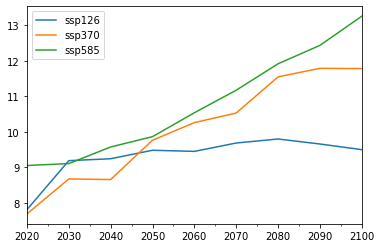

In [18]:
lat,lon = 43.128, -89.42
elevation = 258


fig,ax = plt.subplots()
start_date,end_date = '2020-01-01','2100-12-31'

for ssp in ['ssp126','ssp370','ssp585']:
    model='gfdl-esm4'
    tavg = build_weather_series(lat,lon, elevation,start_date, end_date, historic=historic, 
                                model=model, ssp=ssp, verbose=verbose)

    tavg.columns = pd.date_range(start_date, end_date)
    tavg = tavg.T
    tavg.resample('10Y').mean().plot(ax=ax)
ax.legend(['ssp126','ssp370','ssp585'])
plt.show()

In [19]:
#tavg.resample('1Y').mean().plot()

(283.0, 447.0)

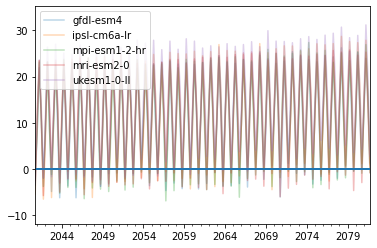

In [20]:

fig,ax = plt.subplots()

for model in ['gfdl-esm4','ipsl-cm6a-lr','mpi-esm1-2-hr','mri-esm2-0','ukesm1-0-ll']:
    tavg = build_weather_series(lat,lon, elevation,start_date, end_date, historic=historic, 
                                model=model, ssp=ssp, verbose=verbose)
    tavg.columns = pd.date_range(start_date, end_date)
    tavg = tavg.T.resample('Q-FEB').mean().T
    tavg.index = [model]
    tavg.T.plot(ax=ax,alpha =0.3)
    ax.axhline(0)
ax.set_xlim('2040-01-01','2080-12-31')


Read in all US lakes, remove match for Peltier Lake, MN

In [21]:
dfmatch = pd.read_csv(f'/Volumes/{volume}/ISIMIP/isimip3b/input/match_index_v2.csv')
dfmatch.loc[dfmatch.lakecode=='xKB1341', 'Match'] = False
dfmatch[dfmatch.Match==True].Distance.unique()

dfmatch[dfmatch.lakecode.isin(['DMR1','DMR2','JJM18'])]

,lakecode,lake,start_date,end_date,lat,lon,Distance,Hylak_id,Match,Lake_name,...,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat,match_index
0,DMR1,mendota,1852,2019,43.128,-89.420,0.0,9086.0,True,Tenny Park Locks,...,2.0,4.8,6.047,377.8,258.0,2.61,640.1,-89.377833,43.086984,454
1,DMR2,monona,1851,2019,43.067,-89.366,0.0,9087.0,True,NaN,...,3.0,6.6,6.856,149.6,256.0,2.36,729.0,-89.339804,43.053292,454
11,JJM18,wingra,1877,2020,43.054,-89.419,0.0,111106.0,True,NaN,...,3.0,3.1,0.204,222.3,257.0,1.69,22.1,-89.407469,43.057780,454


In [28]:
dfice = pd.read_csv('../Data/IcePhenology/us_lakes_ts_minimal.csv', low_memory=False)

df_uslakes = dfice[['lakecode','lake','latitude','longitude']].drop_duplicates()

In [29]:
df_uslakes.head()

,lakecode,lake,latitude,longitude
0,BB1,mercer,46.160,-90.059
24,BB2,turtle_flambeau_flowage,46.075,-90.137
48,CFM1,hilbert,45.708,-88.412
73,DD01,sand,45.920,-92.180
102,DMR1,mendota,43.128,-89.420


Prepare for querying new NOAA weather stations

In [103]:
dfcode = pd.read_csv(f'{OUTPUT_DIR}MSHR_Enhanced_Table.csv')
colspecs = dfcode.POSITION.apply(lambda x: (int(x.split('-')[0])-1,int(x.split('-')[1])))

if os.path.isfile(f'/Volumes/{volume}/WeatherData/NOAA/csv/dfstations.csv'):
    dfstations = pd.read_csv(f'/Volumes/{volume}/WeatherData/NOAA/csv/dfstations.csv',low_memory=False,index_col=0)
else:
    print('Reading in stations file...')
    dfstations = pd.read_fwf(f'{OUTPUT_DIR}mshr_enhanced_202102.txt',
                             names=dfcode.FIELD.values, dtypes=object,
                             colspecs=list(colspecs))

    # remove balloon stations
    dfstations = dfstations[~dfstations.LAT_DEC.isnull() & ~dfstations.LON_DEC.isnull()]

    # fill in with actual date information if the file has been downloaded
    ind = (dfstations.BEGIN_DATE==10101) & dfstations.SOURCE_ID.apply(lambda x: os.path.isfile(f'{CSV_DIR}{x}.csv'))

    print('Getting actual start date for stations with 10101...')
    for i,row in dfstations[ind].iterrows():
        source_id_file = f'{CSV_DIR}{row.SOURCE_ID}.csv'
        df_ = pd.read_csv(source_id_file)
        if len(df_)==0:
            continue
        earliest_date = df_.DATE.min()
        latest_date = df_.DATE.max()
        dfstations.loc[i,'BEGIN_DATE'] = earliest_date.replace('-','')
        dfstations.loc[i,'END_DATE'] = latest_date.replace('-','')



    for i,c in enumerate(dfstations.GHCND_ID.unique()):
        clear_output(wait=True)
        print(f"{i+1:4d}/{len(dfstations.GHCND_ID.unique())}")
        try:
            df_ = pd.read_csv(f'/Volumes/{volume}/WeatherData/NOAA/csv/{c}.csv')
            # look for stations that are missing temperature data
            if len(df_.dropna(how='all',axis=1).columns.intersection(['TMIN','TMAX','TAVG']))==0:
                dfstations.loc[dfstations.GHCND_ID==c,'temperature'] = False
            else:
                dfstations.loc[dfstations.GHCND_ID==c,'temperature'] = True
        except:
            continue
    dfstations.to_csv(f'/Volumes/{volume}/WeatherData/NOAA/csv/dfstations.csv')

    
dfstations_temp = dfstations[dfstations.temperature==True]


In [106]:
#dfstations.to_csv(f'/Volumes/{volume}/WeatherData/NOAA/csv/dfstations.csv')



In [107]:
dfstations.shape

(293299, 54)

Make predictions

In [30]:
#dfmatch
#dficeon_all.lakecode.unique()
#dfmatch[dfmatch.Match]
dfmatch[dfmatch.Match]

,lakecode,lake,start_date,end_date,lat,lon,Distance,Hylak_id,Match,Lake_name,...,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat,match_index
0,DMR1,mendota,1852,2019,43.12800,-89.42000,0.000000,9086.0,True,Tenny Park Locks,...,2.0,4.8,6.047,377.8,258.0,2.61,640.1,-89.377833,43.086984,454
1,DMR2,monona,1851,2019,43.06700,-89.36600,0.000000,9087.0,True,NaN,...,3.0,6.6,6.856,149.6,256.0,2.36,729.0,-89.339804,43.053292,454
2,HB01,mirror,1968,2006,43.94400,-71.69300,0.000000,1047119.0,True,NaN,...,3.0,4.8,0.024,281.9,217.0,5.64,0.9,-71.693675,43.944025,440
3,JD01,kegonsa,1902,2007,42.96600,-89.25100,0.000000,9091.0,True,NaN,...,3.0,5.5,9.135,87.2,256.0,2.03,986.7,-89.223839,42.964546,503
4,JGL01,spirit,1943,2008,43.47700,-95.10200,0.000000,9065.0,True,NaN,...,3.0,2.3,0.980,571.9,425.0,0.84,189.7,-95.103860,43.445607,442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,xKB1640,siseebakwet,1967,2015,47.15701,-93.67103,0.000000,106055.0,True,NaN,...,3.0,6.4,0.321,1105.2,404.0,2.55,41.3,-93.652449,47.159777,53
93,xKB1746,swan,1970,2014,44.91110,-94.23430,0.000000,109652.0,True,NaN,...,3.0,2.3,0.193,174.0,316.0,1.19,29.6,-94.239463,44.906753,297
94,xKB1774,tetonka,1972,2017,44.23052,-93.60736,0.000000,110452.0,True,NaN,...,2.0,18.8,2.477,436.0,303.0,2.37,322.8,-93.573781,44.227123,347
97,xKB1921,washington,1949,2017,44.25335,-93.87293,90.411844,110415.0,True,NaN,...,3.0,4.9,1.283,257.8,297.0,1.75,180.6,-93.892546,44.266087,347


In [31]:
climateNA = True

In [64]:
dficeon_all

,lakecode,index,gfdl-esm4_ssp126,gfdl-esm4_ssp245,gfdl-esm4_ssp370,gfdl-esm4_ssp585,ipsl-cm6a-lr_ssp126,ipsl-cm6a-lr_ssp245,ipsl-cm6a-lr_ssp370,ipsl-cm6a-lr_ssp585,...,mpi-esm1-2-hr_ssp370,mpi-esm1-2-hr_ssp585,mri-esm2-0_ssp126,mri-esm2-0_ssp245,mri-esm2-0_ssp370,mri-esm2-0_ssp585,ukesm1-0-ll_ssp126,ukesm1-0-ll_ssp245,ukesm1-0-ll_ssp370,ukesm1-0-ll_ssp585
0,DMR1,2015.0,-1.0,-9.0,-5.0,-9.0,-999.0,-999.0,-999.0,-999.0,...,-8.0,3.0,7.0,9.0,7.0,3.0,0.0,-3.0,-3.0,-2.0
1,DMR1,2016.0,-6.0,11.0,-6.0,-13.0,-999.0,-999.0,-999.0,-999.0,...,4.0,-2.0,9.0,1.0,-6.0,-10.0,4.0,1.0,6.0,0.0
2,DMR1,2017.0,8.0,-7.0,1.0,1.0,-999.0,-999.0,-999.0,-999.0,...,7.0,5.0,2.0,-7.0,11.0,7.0,5.0,4.0,-2.0,5.0
3,DMR1,2018.0,1.0,-1.0,5.0,2.0,-999.0,-999.0,-999.0,-999.0,...,4.0,-2.0,-9.0,-8.0,-2.0,2.0,1.0,1.0,2.0,6.0
4,DMR1,2019.0,-9.0,8.0,-6.0,-2.0,-999.0,-999.0,-999.0,-999.0,...,-4.0,0.0,-2.0,-10.0,10.0,10.0,4.0,8.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,MINN31,2095.0,-24.0,-30.0,-28.0,-8.0,-999.0,-999.0,-999.0,-999.0,...,-25.0,-26.0,-30.0,-26.0,-17.0,-18.0,-21.0,-16.0,-6.0,-5.0
3396,MINN31,2096.0,-30.0,-26.0,-23.0,-13.0,-999.0,-999.0,-999.0,-999.0,...,-21.0,-24.0,-25.0,-33.0,-26.0,-17.0,-23.0,-14.0,-8.0,-5.0
3397,MINN31,2097.0,-30.0,-28.0,-18.0,-17.0,-999.0,-999.0,-999.0,-999.0,...,-24.0,-26.0,-28.0,-23.0,-21.0,-14.0,-18.0,-13.0,-6.0,-5.0
3398,MINN31,2098.0,-28.0,-12.0,-22.0,-7.0,-999.0,-999.0,-999.0,-999.0,...,-20.0,-19.0,-28.0,-28.0,-16.0,-6.0,-21.0,-14.0,-6.0,-5.0


In [86]:
dfus

,ID1,ID2,lat,long,el
0,mendota,DMR1,43.1280,-89.420,258.0
1,monona,DMR2,43.0670,-89.366,256.0
2,anderson,ETJ1,46.1710,-89.344,.
3,auburn,GAH1,44.1444,-70.250,79.0
4,kezar,GAH10,44.1930,-70.901,114.0
...,...,...,...,...,...
262,morey,xMM058,43.9220,-72.152,128.0
263,raponda,xMM070,42.8750,-72.818,559.0
264,seymour,xMM079,44.8970,-71.989,390.0
265,st.catherine,xMM089,43.4660,-73.215,144.0


Create file for ClimateNA

In [89]:
dfmatch[dfmatch.Match][['lake','lakecode','lat','lon','Elevation']].rename(
    {'lake':'ID1','lakecode':'ID2','Elevation':'el','lon':'long'},axis=1).round(7).to_csv(
    '/Users/blagrave/Desktop/Folder to share/US_icephenologymodels74lakes.csv',index=False,
line_terminator='\r')

In [91]:
try:
    display(dficeon_all)
except:
    dficeon_all = pd.DataFrame(columns=['lakecode'])
    dficeoff_all = pd.DataFrame(columns=['lakecode'])

for i,row in dfmatch[dfmatch.Match].iterrows():
    #if row.lakecode!='MICH06':
    #    continue
    if row.lakecode in dficeon_all.lakecode.unique():
        continue
    
    #mendota
    #lat, lon = 43.128, -89.42
    lat,lon = row.lat,row.lon

    
    iceon = []
    iceoff = []
    
    dficeon = pd.DataFrame(index=range(2015,2100))
    dficeoff = pd.DataFrame(index=range(2015,2100))

    # match2hydrolakes(lat,lon)
    hylak_dist, hylak_id = match2hydrolakes(lat, lon)
    if np.isnan(hylak_dist):
        print('No HydroLAKES match at this coordinate. You need to supply depth_avg, lake_area, shore_len.')
        #print(f'\tClosest HydroLAKES lake {hylak_id} is {hylak_dist:.1f} km away.')
        break
        #continue
    lakechar = get_hylak_info(hylak_id)
    
    for model in ['gfdl-esm4','ipsl-cm6a-lr','mpi-esm1-2-hr','mri-esm2-0','ukesm1-0-ll']:
        for ssp in ['ssp126','ssp245','ssp370','ssp585']:
            iceon= []
            iceoff = []
            for y in range(2015,2100):
                clear_output(wait=True)
                print(row.lakecode, model, ssp, y)
                try:
                    ion,ioff = predict_phenology(lat,lon, y, historic=False, 
                                             rf_model='seasonal', 
                                             depth_avg=lakechar['Depth_avg'],
                                             lake_area=lakechar['Lake_area'],
                                             shore_dev=lakechar['Shore_dev'],
                                             elevation=lakechar['Elevation'],
                                             slope_100=lakechar['Slope_100'],
                                             model=model, 
                                             climateNA=climateNA,
                                             ssp = ssp, 
                                             extrapolation = True,
                                             verbose=False)
                    iceon.append(ion)
                    iceoff.append(ioff)
                    print(ion,ioff)
                    #asdf
                except:
                    print('File not found.')
                    print(lat,lon, y, lakechar,model,ssp)
                    iceon.append(-999)
                    iceoff.append(-999)
                    if model!='ipsl-cm6a-lr':
                        asdf
                    #asdf
                    
            dficeon.loc[:,f"{model}_{ssp}"] = iceon
            dficeoff.loc[:,f"{model}_{ssp}"] = iceoff

    dficeon['lakecode'] = row.lakecode
    dficeoff['lakecode'] = row.lakecode
    dficeon_all = dficeon_all.append(dficeon.reset_index(),ignore_index=True)
    dficeoff_all = dficeoff_all.append(dficeoff.reset_index(),ignore_index=True)
    

xKB1987 ukesm1-0-ll ssp585 2099
equal 2
close 2
-5 56


In [93]:
#dficeon_all_orig = dficeon_all.copy()
#dficeoff_all_orig = dficeoff_all.copy()
#dficeoff_all

,lakecode,index,gfdl-esm4_ssp126,gfdl-esm4_ssp245,gfdl-esm4_ssp370,gfdl-esm4_ssp585,ipsl-cm6a-lr_ssp126,ipsl-cm6a-lr_ssp245,ipsl-cm6a-lr_ssp370,ipsl-cm6a-lr_ssp585,...,mpi-esm1-2-hr_ssp370,mpi-esm1-2-hr_ssp585,mri-esm2-0_ssp126,mri-esm2-0_ssp245,mri-esm2-0_ssp370,mri-esm2-0_ssp585,ukesm1-0-ll_ssp126,ukesm1-0-ll_ssp245,ukesm1-0-ll_ssp370,ukesm1-0-ll_ssp585
0,DMR1,2015.0,89.0,98.0,92.0,98.0,-999.0,-999.0,-999.0,-999.0,...,92.0,81.0,68.0,75.0,71.0,80.0,89.0,94.0,90.0,91.0
1,DMR1,2016.0,96.0,76.0,90.0,96.0,-999.0,-999.0,-999.0,-999.0,...,88.0,91.0,72.0,87.0,97.0,96.0,75.0,92.0,78.0,85.0
2,DMR1,2017.0,67.0,92.0,89.0,83.0,-999.0,-999.0,-999.0,-999.0,...,79.0,78.0,78.0,89.0,67.0,68.0,90.0,92.0,92.0,69.0
3,DMR1,2018.0,75.0,90.0,73.0,87.0,-999.0,-999.0,-999.0,-999.0,...,76.0,86.0,94.0,92.0,87.0,91.0,82.0,91.0,91.0,88.0
4,DMR1,2019.0,97.0,96.0,98.0,94.0,-999.0,-999.0,-999.0,-999.0,...,87.0,88.0,76.0,99.0,77.0,64.0,92.0,77.0,90.0,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6285,xKB1987,2095.0,86.0,91.0,91.0,61.0,-999.0,-999.0,-999.0,-999.0,...,90.0,89.0,98.0,80.0,65.0,61.0,68.0,61.0,56.0,56.0
6286,xKB1987,2096.0,89.0,102.0,90.0,62.0,-999.0,-999.0,-999.0,-999.0,...,68.0,77.0,96.0,91.0,77.0,68.0,79.0,61.0,57.0,56.0
6287,xKB1987,2097.0,91.0,83.0,64.0,61.0,-999.0,-999.0,-999.0,-999.0,...,89.0,89.0,80.0,69.0,69.0,61.0,61.0,60.0,56.0,56.0
6288,xKB1987,2098.0,98.0,63.0,69.0,56.0,-999.0,-999.0,-999.0,-999.0,...,68.0,63.0,92.0,90.0,62.0,56.0,69.0,60.0,56.0,56.0


In [94]:
#dficeon_all = dficeon_all_orig[~dficeon_all_orig.lakecode.isin(dficeon_all_orig[(dficeon_all_orig['gfdl-esm4_ssp126']==-999)].lakecode.unique())]
#dficeoff_all = dficeoff_all_orig[~dficeoff_all_orig.lakecode.isin(dficeon_all_orig[(dficeon_all_orig['gfdl-esm4_ssp126']==-999)].lakecode.unique())]
#print(dficeon_all.shape, dficeoff_all.shape, dficeon_all_orig.shape, dficeoff_all_orig.shape)

In [95]:
# v4 is model that excludes Peltier Lake, MN
# v5 has been corrected for x/y y/x mix up. all previous versions are WRONG
# v6 is with model _v10b (i.e., no slope_100)
# v7 is with extrapolation = True 
# v8 is with extrapolation & with model that uses new weather series
# v9 is ClimateNA including ssp245 and no IPSL model
#dficeon_all.to_csv('/Users/blagrave/Projects/IcePhenologyModels/IceModels/model_predictions_iceon_v8.csv',index=False)
#dficeoff_all.to_csv('/Users/blagrave/Projects/IcePhenologyModels/IceModels/model_predictions_iceoff_v8.csv',index=False)

dficeon_all.to_csv('/Users/blagrave/Projects/IcePhenologyModels/IceModels/model_predictions_iceon_v9.csv',index=False)
dficeoff_all.to_csv('/Users/blagrave/Projects/IcePhenologyModels/IceModels/model_predictions_iceoff_v9.csv',index=False)



Predict historical using same models for all years back to 1980.

In [110]:
dficeon_hist = pd.DataFrame()
dficeoff_hist = pd.DataFrame()
for i,row in dfmatch[dfmatch.Match].iterrows():
    
    lat,lon = row.lat, row.lon
    iceon,iceoff = [],[]
    
    dficeon = pd.DataFrame(index=range(1960,2021))
    dficeoff = pd.DataFrame(index=range(1960,2021))

    hylak_dist, hylak_id = match2hydrolakes(lat, lon)
    if np.isnan(hylak_dist):
        print('No HydroLAKES match at this coordinate. You need to supply depth_avg, lake_area, shore_len.')
        #print(f'\tClosest HydroLAKES lake {hylak_id} is {hylak_dist:.1f} km away.')
        break
        #continue
    lakechar = get_hylak_info(hylak_id)

    print(row.lakecode, hylak_id)
    iceon,iceoff = predict_phenology(lat,lon, list(range(1960,2021)), historic=True, 
                                 rf_model='seasonal', 
                                 depth_avg=lakechar['Depth_avg'],
                                 lake_area=lakechar['Lake_area'],
                                 shore_dev=lakechar['Shore_dev'],
                                 elevation=lakechar['Elevation'],
                                 slope_100=lakechar['Slope_100'],
                                 #model=model, 
                                 #ssp = ssp, 
                                 verbose=False)
    dficeon.loc[:,'historical'] = iceon
    dficeoff.loc[:,'historical'] = iceoff
    dficeon['lakecode'] = row.lakecode
    dficeoff['lakecode'] = row.lakecode
    dficeon_hist = dficeon_hist.append(dficeon.reset_index(),ignore_index=True)
    dficeoff_hist = dficeoff_hist.append(dficeoff.reset_index(),ignore_index=True)

DMR1 9086


KeyboardInterrupt: 

In [ ]:
dficeoff_hist.lakecode.unique().shape

In [111]:
suffix

'_v11'

In [ ]:
dficeon_hist.rename({'index':'year','historical':'ypred'},axis=1).to_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon_limited_seasonal_8params{suffix}_predictionsB.csv',index=False)
dficeoff_hist.rename({'index':'year','historical':'ypred'},axis=1).to_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff_limited_seasonal_6params{suffix}_predictionsB.csv',index=False)

___

In [96]:
STOP HERE

SyntaxError: invalid syntax (3031286301.py, line 1)

In [236]:
"""
lat,lon = 43.128, -89.42
predict_phenology(lat,lon, 2068, historic=False, 
                                             rf_model='seasonal', 
                                             depth_avg=lakechar['Depth_avg'],
                                             lake_area=lakechar['Lake_area'],
                                             shore_dev=lakechar['Shore_dev'],
                                             elevation=lakechar['Elevation'],
                                             slope_100=lakechar['Slope_100'],
                                             model='ukesm1-0-ll', 
                                             ssp = 'ssp585', 
                                             verbose=False)
"""

"\nlat,lon = 43.128, -89.42\npredict_phenology(lat,lon, 2068, historic=False, \n                                             rf_model='seasonal', \n                                             depth_avg=lakechar['Depth_avg'],\n                                             lake_area=lakechar['Lake_area'],\n                                             shore_dev=lakechar['Shore_dev'],\n                                             elevation=lakechar['Elevation'],\n                                             slope_100=lakechar['Slope_100'],\n                                             model='ukesm1-0-ll', \n                                             ssp = 'ssp585', \n                                             verbose=False)\n"

In [29]:
lat,lon = 43.128, -89.42

hylak_dist, hylak_id = match2hydrolakes(lat, lon)

lakechar = get_hylak_info(hylak_id)
model = 'ukesm1-0-ll'
ssp = 'ssp585'
y = 2059
ion,ioff = predict_phenology(lat,lon, y, historic=False, 
                                             rf_model='seasonal', 
                                             depth_avg=lakechar['Depth_avg'],
                                             lake_area=lakechar['Lake_area'],
                                             shore_dev=lakechar['Shore_dev'],
                                             elevation=lakechar['Elevation'],
                                             slope_100=lakechar['Slope_100'],
                                             model=model, 
                                             ssp = ssp, 
                                             verbose=True)

Building weather time series for coordinate (43.128,-89.420)
  01 June, 2059 to 31 May, 2060

Missing days in Tavg series: 0


,TMINMAX_lagJJA,TMINMAX_lagSON,TMINMAX_DJF,TMINMAX_MAM
Tavg,25.503709,9.802496,-0.100049,7.451955


In [30]:
ion, ioff

(7, 65)

In [142]:
dficeon_all.to_csv(f'/Volumes/{volume}/IceModels/model_predictions_iceon_v2.csv',index=False)
dficeoff_all.to_csv(f'/Volumes/{volume}/IceModels/model_predictions_iceoff_v2.csv',index=False)


Check which lakes are not well-represented by ISIMIP3b 0.5 degree grid cell.

In [10]:
df_data0 = pd.read_csv(f'/Volumes/{volume}/IceModels/merged_model_input.csv')


In [21]:
df_data0[df_data0.lakecode=='DMR1'][['lat','lon']]

,lat,lon
0,43.128,-89.42
1,43.128,-89.42
2,43.128,-89.42
3,43.128,-89.42
4,43.128,-89.42
...,...,...
146,43.128,-89.42
147,43.128,-89.42
148,43.128,-89.42
149,43.128,-89.42


In [22]:
lat = 43.128
lon = -89.42
start_date = '1 Jan 1850'
end_date = '31 Dec 2014'
model = 'gfdl-esm4'
ts = build_isimip_weather_series(lat,lon,start_date,end_date, historic=True, model = model).set_index('DATE')

<AxesSubplot:xlabel='DATE'>

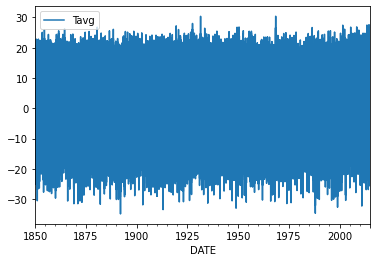

In [24]:
ts.plot()

In [11]:
dfresult = pd.DataFrame()
for name, group in df_data0.groupby('lakecode'):
    lat, lon = group.lat.unique()[0],group.lon.unique()[0]
    start_date = f"1 June {group.start_year.min()}"
    end_date = f"31 May {group.start_year.max()+1}"
    group2 = group.copy()
    for model in ['gfdl-esm4','ipsl-cm6a-lr','mpi-esm1-2-hr','mri-esm2-0','ukesm1-0-ll']:
        ts = build_isimip_weather_series(lat,lon,start_date,end_date, historic=True, model = model).set_index('DATE')
        ts = ts.resample('Q-FEB').mean()
        #break
        ts['start_year'] = [j.year if j.month > 6 else j.year-1 for j in ts.index]
        ts = ts.rename({j: j.strftime('%B')[0] for j in ts.index},axis=0).reset_index().pivot_table(values='Tavg',columns='DATE',sort=False,index='start_year')
        ts = ts[['A','N','F','M']].rename({'A':f'{model}_JJA','N':f'{model}_SON','F':f'{model}_DJF','M':f'{model}_MAM'},axis=1)
      
        group2 = group2.merge(ts,left_on='start_year',right_index=True, how='outer')
        #ts = ts.rename({j: j.strftime('%B')[0] for j in ts.columns},axis=1).rename({'A':f'{model}_JJA','N':f'{model}_SON','F':f'{model}_DJF','M':f'{model}_MAM'},axis=1).rename({'Tavg':i})
    dfresult = dfresult.append(group2,ignore_index=True)
    print(name,'DONE')
    
    

DMR1 DONE
DMR2 DONE
HB01 DONE
JD01 DONE
JGL01 DONE
JGL02 DONE
JGL03 DONE
JJM1 DONE
JJM14 DONE
JJM15 DONE
JJM17 DONE
JJM18 DONE
JJM19 DONE
JJM2 DONE
JJM22 DONE
JJM23 DONE
JJM24 DONE
JJM26 DONE
JJM27 DONE
JJM28 DONE
JJM3 DONE
JJM30 DONE
JJM33 DONE
JJM4 DONE
JJM6 DONE
JJM7 DONE
JJM8 DONE
JJM9 DONE
KMS10 DONE
KMS11 DONE
KMS12 DONE
KMS14 DONE
KMS15 DONE
KMS17 DONE
KMS18 DONE
KMS19 DONE
KMS2 DONE
KMS23 DONE
KMS24 DONE
KMS25 DONE
KMS26 DONE
KMS27 DONE
KMS5 DONE
KMS6 DONE
KMS8 DONE
KMS9 DONE
LR1 DONE
LR2 DONE
MICH03 DONE
MICH06 DONE
MINN12 DONE
MINN2 DONE
MINN31 DONE
MINN34 DONE
MINN37 DONE
MINN38 DONE
MINN4 DONE
MINN6 DONE
MINN7 DONE
RAA3 DONE
RAA4 DONE
xKB0014 DONE
xKB0019 DONE
xKB0051 DONE
xKB0162 DONE
xKB0230 DONE
xKB0263 DONE
xKB0269 DONE
xKB0364 DONE
xKB0499 DONE
xKB0555 DONE
xKB0559 DONE
xKB0565 DONE
xKB0677 DONE
xKB0728 DONE
xKB0781 DONE
xKB0798 DONE
xKB0872 DONE
xKB0937 DONE
xKB0980 DONE
xKB0990 DONE
xKB1045 DONE
xKB1047 DONE
xKB1121 DONE
xKB1139 DONE
xKB1162 DONE
xKB1317 DONE
xKB1341

In [18]:
#dfresult.groupby('lakecode').mean()['TMINMAX_lagJJA']|
dfresult

,-183,-182,-181,-180,-179,-178,-177,-176,-175,-174,...,mpi-esm1-2-hr_DJF,mpi-esm1-2-hr_MAM,mri-esm2-0_JJA,mri-esm2-0_SON,mri-esm2-0_DJF,mri-esm2-0_MAM,ukesm1-0-ll_JJA,ukesm1-0-ll_SON,ukesm1-0-ll_DJF,ukesm1-0-ll_MAM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.479277,2.015585,16.864876,5.713475,-11.040146,4.319088,17.661202,6.677031,-8.915801,2.043412
1,22.50,21.95,23.35,17.80,18.65,20.85,21.35,21.40,23.10,24.45,...,-9.210257,1.544546,17.072038,5.128474,-11.387945,3.940968,18.098510,7.215219,-9.616336,2.937363
2,18.60,23.35,25.85,23.90,23.90,21.95,16.90,18.60,25.00,23.05,...,-7.657096,2.867273,16.963490,5.540393,-11.259584,5.180434,16.422142,7.339535,-7.825144,4.414064
3,20.55,22.20,21.10,21.15,23.90,21.65,22.80,27.75,22.80,19.45,...,-8.620352,1.848858,16.910794,4.786191,-12.530823,2.391713,16.451140,7.526378,-11.189862,3.467608
4,26.65,26.95,23.90,19.75,20.25,21.95,23.30,24.75,24.45,26.70,...,-10.439183,2.564321,16.366011,5.783520,-12.247491,2.599100,15.307126,4.442876,-6.938562,4.430716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7460,28.60,31.10,28.05,32.75,30.85,28.90,23.90,26.95,25.60,24.70,...,-11.888230,3.018006,17.526169,4.152162,-11.593867,4.016072,18.775889,7.904670,-10.158017,2.032975
7461,23.30,22.20,22.50,25.55,26.95,28.85,27.80,25.55,26.15,22.75,...,-13.233768,3.490992,17.247483,6.812095,-7.422111,1.947038,17.002353,5.401180,-9.686296,1.797650
7462,18.35,17.75,20.00,20.60,23.60,26.40,24.45,20.85,20.25,22.75,...,-10.904016,NaN,18.473136,7.632083,-7.698974,NaN,17.697067,6.256816,-9.771149,NaN
7463,18.90,19.15,21.15,23.85,25.00,19.40,17.20,18.35,21.40,23.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
from matplotlib import pyplot as plt
df_diff = pd.DataFrame()
for name,group in dfresult.groupby('lakecode'):
    #display(group)
    diffs = []
    for season in ['JJA','SON','DJF','MAM']:
        c = [i for i in group.columns if (season in i) & ('TMINMAX' not in i)]
        X = group[c]
        y = group[[i for i in group.columns if (season in i) & ('TMINMAX' in i)]]
        models = X.mean().median()
        observed = y.mean().values[0]
        #print(models, observed, observed - models)
        df_diff = df_diff.append(pd.DataFrame({'lakecode':name,'season':season,'diff':observed - models},index=[0]),ignore_index=True)
        #plt.plot(X,y,marker='.',ls='none')
    #plt.plot([0,1],[0,1])
    #diff_dict[name] = np.mean(diffs)
#    break
df_diff = df_diff.pivot_table(values='diff',columns='season',index='lakecode')

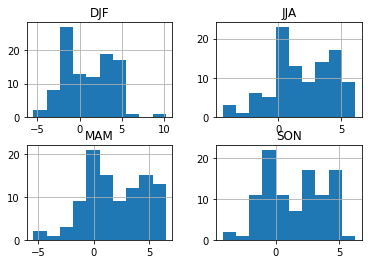

In [14]:
df_diff.hist()
df_diff.to_csv(f'/Volumes/{volume}/IceModels/isimip_weather_differences_by_lakecode.csv',index=True)

In [15]:
df_diff[(np.abs(df_diff)>5).any(axis=1) & df_diff.index.isin(df_data0[~df_data0.Depth_avg.isnull()].lakecode)]#.shape

season,DJF,JJA,MAM,SON
lakecode,,,,
DMR2,5.150703,4.876479,4.945882,4.910030
JD01,5.325066,3.871349,4.645230,4.548718
JGL01,4.304696,5.927984,5.546992,4.275340
JJM18,5.343398,4.875131,4.997690,5.002660
JJM24,5.159613,4.485051,5.167746,4.668782
KMS17,-5.457606,-4.397785,-5.420960,-4.142654
KMS24,-3.014607,-4.412602,-5.228716,-3.353425
MICH03,10.206036,4.627509,6.385152,6.216991
MICH06,5.954314,2.387331,3.317524,4.261102
